# Phase separation tutorial
In this tutorial, we first load a two-phase PIV image and then use different phase separation methods to discriminate the phases and save them as two images.

In [1]:
from openpiv import tools, phase_separation
import matplotlib.pyplot as plt
%matplotlib inline

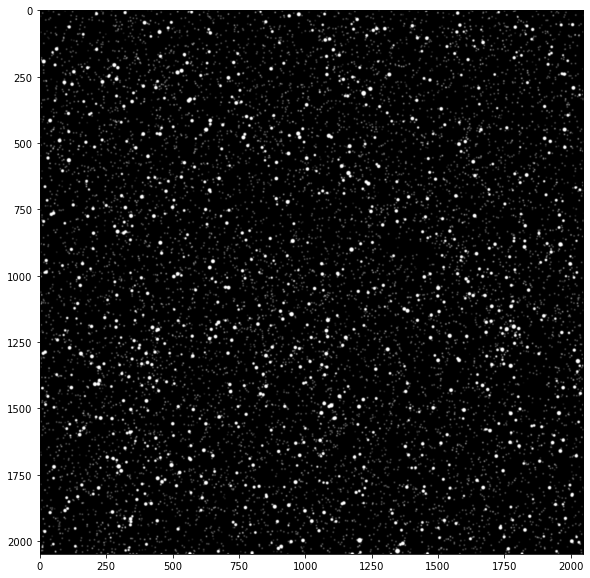

In [2]:
two_phase_image = tools.imread('../two_phase_piv/image_A.tif')
plt.figure(figsize=(10,10))
plt.imshow(two_phase_image ,cmap=plt.cm.gray)
plt.show()

## Opening method

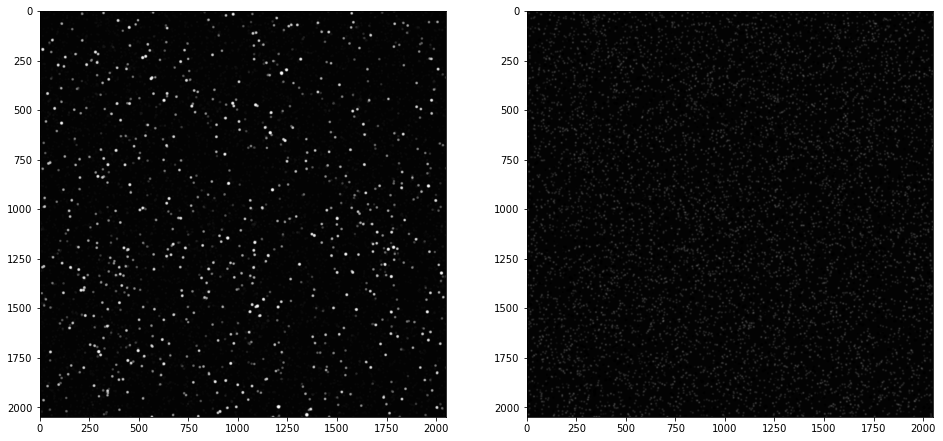

In [3]:
big_particles_image, small_particles_image = phase_separation.opening_method(two_phase_image,11)
fig, ax = plt.subplots(1, 2, figsize=(16,10))
ax[0].imshow( big_particles_image, cmap=plt.cm.gray, vmin=0, vmax=255 )
ax[1].imshow( small_particles_image, cmap=plt.cm.gray, interpolation='bicubic', vmin=0, vmax=255 )
plt.show()

## Median filter method

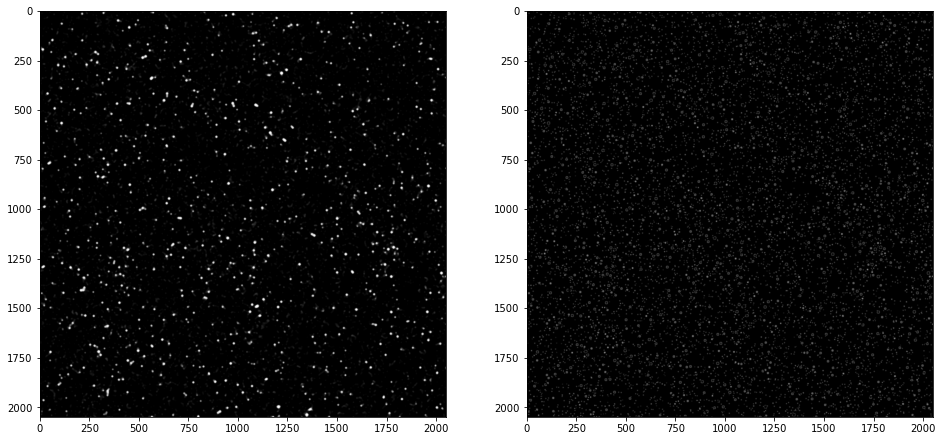

In [4]:
big_particles_image, small_particles_image = phase_separation.median_filter_method(two_phase_image, 11)
fig, ax = plt.subplots(1, 2, figsize=(16,10))
ax[0].imshow( big_particles_image, cmap=plt.cm.gray )
ax[1].imshow( small_particles_image, cmap=plt.cm.gray, vmin=0, vmax=255 )
plt.show()

## Khalitov-Longmire method

### Using a simple size limit

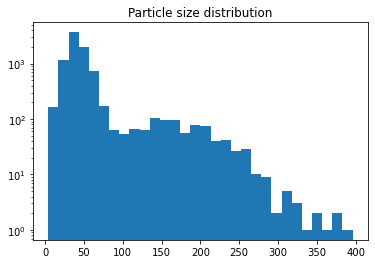

In [5]:
# Plot size distribution
plt.hist( phase_separation.get_particles_size_array(two_phase_image), 30)
plt.yscale('log')
plt.title('Particle size distribution')
plt.show()

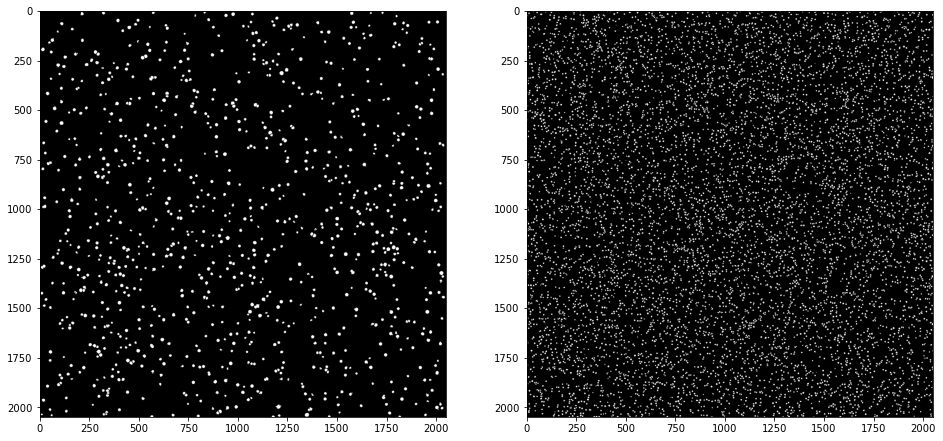

In [6]:
# Choose size limit = 100 
big_particles_criteria = {'min_size' : 75}
small_particles_criteria = {'max_size' : 75}
big_particles_image, small_particles_image = \
    phase_separation.khalitov_longmire( two_phase_image, big_particles_criteria, small_particles_criteria ) 
fig, ax = plt.subplots(1, 2, figsize=(16,10))
ax[0].imshow( big_particles_image, cmap=plt.cm.gray)
ax[1].imshow( small_particles_image, cmap=plt.cm.gray)
plt.show()

### Using size and brightness limits

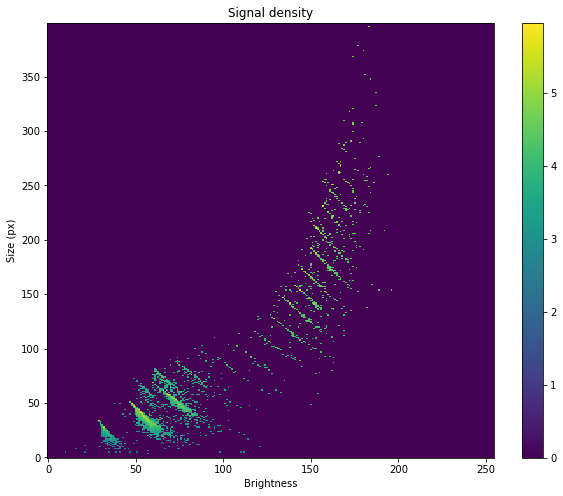

In [7]:
# First plot size-brightness map
sb_map = phase_separation.get_size_brightness_map( two_phase_image ) # It is possible to sum over maps of multiple images
plt.figure(figsize=(10,8))
plt.imshow( sb_map, interpolation='nearest', aspect='auto', origin='lower' )
plt.colorbar()
plt.xlabel('Brightness')
plt.ylabel('Size (px)')
plt.title('Signal density')
plt.show()

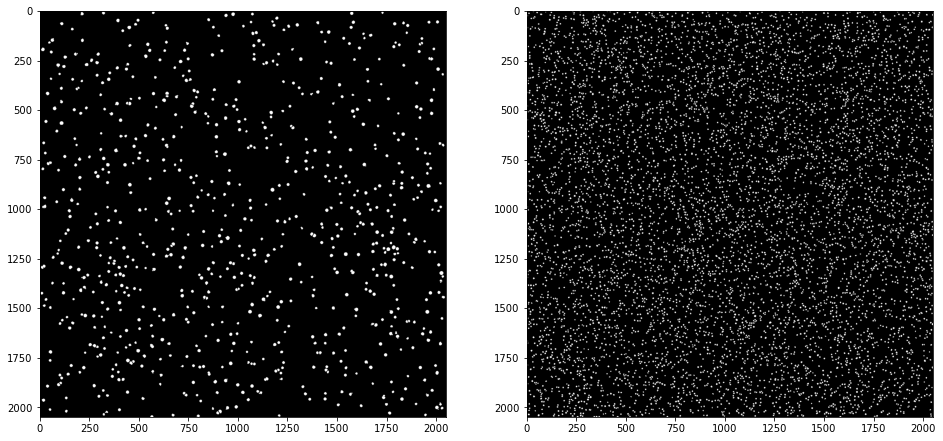

In [8]:
# size-brightness rectangle regions 
big_particles_criteria = {
    'min_size' : 100 ,'max_size' : 350 , 'min_brightness' : 100 , 'max_brightness' : 180 }
small_particles_criteria = {
    'min_size' : 25 ,'max_size' : 100 , 'min_brightness' : 30 , 'max_brightness' : 100}
big_particles_image , small_particles_image = \
    phase_separation.khalitov_longmire( two_phase_image, big_particles_criteria, small_particles_criteria ) 
fig, ax = plt.subplots(1, 2, figsize=(16,10))
ax[0].imshow( big_particles_image, cmap=plt.cm.gray)
ax[1].imshow( small_particles_image, cmap=plt.cm.gray)
plt.show()